# Image Warping Lab

## Part 1: Interpolation

Since we are going to be warping images, we need to make sure we have a good interpolation function to deal with inexact pixel locations.

In the cell below, we want to scale an image by a factor of 2.30 in both x and y. **Write a function called "interpolate" that performs bilinear interpolation.** This function should take in the image and a location (x,y) of interest. It then uses the nearby pixels to interpolate and return an RGB value.

**Note:** For this lab, we will keep images as floats to simplify the interpolation. Thus, output your images as values between 0-1, not 0-255.

0.99215686


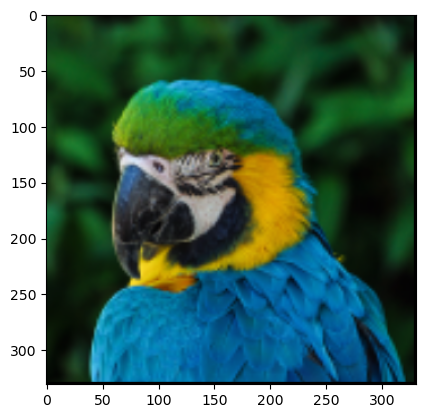

In [172]:
import matplotlib.pyplot as plt
import numpy as np

#Your bilinear interpolation function
def interpolate(image, x, y):
    # Get integer coordinates
    x1, y1 = int(np.floor(x)), int(np.floor(y))
    x2, y2 = x1 + 1, y1 + 1
    
    # Ensure coordinates are within bounds
    x1 = np.clip(x1, 0, image.shape[1] - 1)
    y1 = np.clip(y1, 0, image.shape[0] - 1)
    x2 = np.clip(x2, 0, image.shape[1] - 1)
    y2 = np.clip(y2, 0, image.shape[0] - 1)

    # Calculate distances
    dx1, dx2 = x - x1, x2 - x
    dy1, dy2 = y - y1, y2 - y

    # Fetch pixel values for the four neighbors
    Q11 = image[y1, x1]
    Q21 = image[y1, x2]
    Q12 = image[y2, x1]
    Q22 = image[y2, x2]

    # Perform bilinear interpolation
    R1 = (dx2 * Q11 + dx1 * Q21)
    R2 = (dx2 * Q12 + dx1 * Q22)
    P = (dy2 * R1 + dy1 * R2)

    return P



filename = "test.png"
im = plt.imread(filename)

print(np.amax(im)) #Image values should be between 0-1, not 0-255

h,w,_ = im.shape

result = np.zeros((int(2.3*h),(int(2.3*w)),3), dtype="float32")

rows, cols, _ = result.shape

# Map each new point back to the original image
for i in range(rows):
    for j in range(cols):
        result[i,j] = interpolate(im, j/2.3, i/2.3)

        
plt.imshow(result,vmin=0)
plt.show()

## Part 2: Compose (i.e. Backwards Mapping)

Now that we have a interpolation function, we need a function that can compose a source image onto a target image given a transform. In Lab 3, we used Pillow's built-in compose function. You will now implement this yourself using backwards mapping. **This function should also call your interpolate function.**

To implement this function,
- Invert the given transformation. (This is really easy using the NumPy *linalg* library)
- For each pixel in the target image
  - Determine the x and y coordinates of the pixel
  - Homogenize the coordinate
  - Multiply it by the inverse transform
  - Perform the homogenous divide on the new point
  - If the x,y coordinate is within the boundaries of the source image, grab the interpolated value from source image. Otherwise, keep the original pixel in the target image.

For this example, a simple rotation transformation will be given. The source and target image will be the same size, which means part of your rotated image will be cut off on the corners. If done correctly, you should see the parrot rotated onto a purple background. You can assume that all pixels need to be backward mapped. Any pixel/point that maps to a point outside the image boundaries should be skipped. **Don't forget the homogenous divide.**

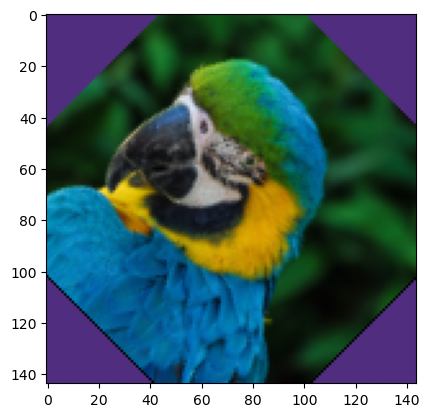

In [173]:
# Compose function with backwards mapping
def compose(source_im, target_im, transform):
    if len(target_im.shape) == 2:  # Grayscale target
        ht, wt = target_im.shape
        result = np.copy(target_im)
    else:  # RGB target
        ht, wt, _ = target_im.shape
        result = np.copy(target_im)

    if len(source_im.shape) == 3:  # RGB source
        hs, ws, _ = source_im.shape
    else:  # Grayscale source
        hs, ws = source_im.shape

    inverse_transform = np.linalg.inv(transform)

    # Iterate over each pixel in the target image
    for i in range(ht):
        for j in range(wt):
            target_coord = np.array([j, i, 1])
            source_coord = inverse_transform @ target_coord
            source_coord = np.squeeze(np.asarray(source_coord))

            source_x, source_y, w = source_coord
            if w != 0:
                source_x /= w
                source_y /= w

            # If the coordinates are within the boundaries of the source image, interpolate
            if 0 <= source_x < ws and 0 <= source_y < hs:
                if len(source_im.shape) == 3:  # Color image
                    interpolated_value = interpolate(source_im, source_x, source_y)
                    if len(result.shape) == 2:  # Target is grayscale
                        result[i, j] = np.mean(interpolated_value)  # Convert RGB to grayscale
                    else:  # Target is color
                        result[i, j] = interpolated_value
                else:  # Grayscale image
                    result[i, j] = interpolate(source_im, source_x, source_y)

    return result


from math import sin,cos,pi

filename = "test.png"
im = plt.imread(filename)
canvas = np.zeros_like(im) + np.array([[[80/255,45/255,127/255]]]) #ECU Purple

transform = np.matrix([[cos(45 * pi/180), -sin(45 * pi/180), w/2],[sin(45 * pi/180),cos(45 * pi/180),-h/5],[0,0,1]])

result = compose(im,canvas,transform)

plt.imshow(result,vmin=0)
plt.show()


## Part 3: Perspective Warp

Now that we have the two specific functions that we need, let's start looking at some more interesting image warping. In class, we discussed how we can use homographies to perform perspective warps. In this lab, we have provided the homography generating code for you. 

In [174]:
class Point():
    def __init__(self,x,y):
        self.x = x
        self.y = y

    def __str__(self):
        return "({},{})".format(self.x,self.y)
    
    def __repr__(self):
        return self.__str__()


def getHomography(s0,s1,s2,s3,t0,t1,t2,t3):

    x0s = s0.x
    y0s = s0.y
    x0t = t0.x
    y0t = t0.y

    x1s = s1.x
    y1s = s1.y
    x1t = t1.x
    y1t = t1.y

    x2s = s2.x
    y2s = s2.y
    x2t = t2.x
    y2t = t2.y

    x3s = s3.x
    y3s = s3.y
    x3t = t3.x
    y3t = t3.y

    #Solve for the homography matrix
    A = np.matrix([
            [x0s, y0s, 1, 0, 0, 0, -x0t*x0s, -x0t*y0s],
            [0, 0, 0, x0s, y0s, 1, -y0t*x0s, -y0t*y0s],
            [x1s, y1s, 1, 0, 0, 0, -x1t*x1s, -x1t*y1s],
            [0, 0, 0, x1s, y1s, 1, -y1t*x1s, -y1t*y1s],
            [x2s, y2s, 1, 0, 0, 0, -x2t*x2s, -x2t*y2s],
            [0, 0, 0, x2s, y2s, 1, -y2t*x2s, -y2t*y2s],
            [x3s, y3s, 1, 0, 0, 0, -x3t*x3s, -x3t*y3s],
            [0, 0, 0, x3s, y3s, 1, -y3t*x3s, -y3t*y3s]
        ])

    b = np.matrix([
            [x0t],
            [y0t],
            [x1t],
            [y1t],
            [x2t],
            [y2t],
            [x3t],
            [y3t]
        ])

    #The homorgraphy solutions a-h
    solutions = np.linalg.solve(A,b)

    solutions = np.append(solutions,[[1.0]], axis=0)

    #Reshape the homography into the appropriate 3x3 matrix
    homography = np.reshape(solutions, (3,3))
    
    return homography

We want to be able to get a new image into the TV set in the image shown below. 

To place the bird correctly inside the TV, do the following:

- Determine the homography that maps from the bird image to the TV. Use the `getHomography` function and the provided points.

- For each pixel/point within the target image, backmap those points onto the bird image. Use your `compose` function and make sure it correctly rejects points that do not land within the image boundary

Write a general perspective warp function that completes these steps. **Hint: If your compose/backmap function is written correctly, this should only be 2-3 lines of code.**

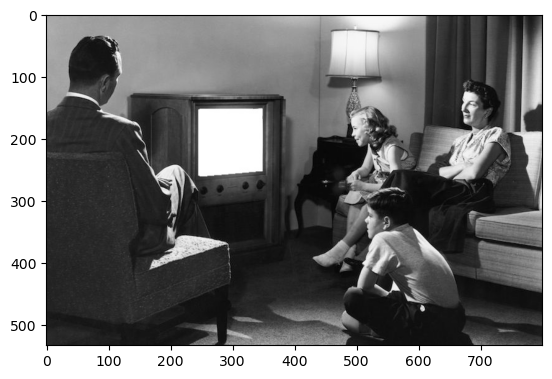

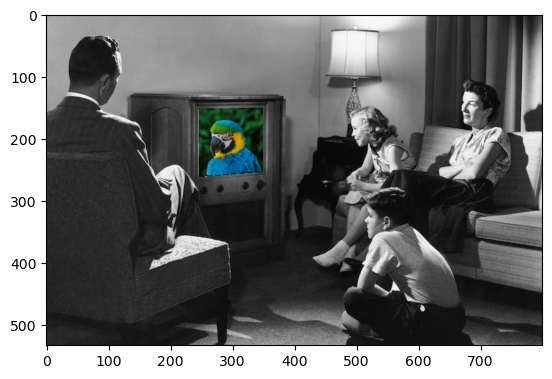

In [175]:
def perspectiveWarp(source_im, target_im, s0, s1, s2, s3, t0, t1, t2, t3):
    result = np.copy(target_im)

    # Get the homography matrix
    homography = getHomography(s0, s1, s2, s3, t0, t1, t2, t3)

    # Use the compose function to warp the image
    result = compose(source_im, target_im, homography)

    return result
    

filename = "test.png"
im = plt.imread(filename)

h,w,_ = im.shape
        
s0 = Point(0,0)
s1 = Point(w-1,0)
s2 = Point(w-1,h-1)
s3 = Point(0,h-1)

t0 = Point(245,152)
t1 = Point(349,150)
t2 = Point(349,253)
t3 = Point(246,261)

tv = plt.imread('tv.png')
plt.imshow(tv,vmin=0)
plt.show()

result = perspectiveWarp(im,tv,s0,s1,s2,s3,t0,t1,t2,t3)

plt.imshow(result,vmin=0)
plt.show()


# Part 4: Speed Up

We have a complete perspective warping algorithm now, but you may have noticed that it runs a little slowly. This is because it checks every pixel in the target image to see if it needs to be backmapped. A much faster solution is create a min-max bounding box around the warping points and only checking pixels within that bounding box. **See the bounding box example image provided with the lab.** You may find `np.amax()` and `np.amin()` to be helpful.

For this last part of the lab, rewrite your perspective warp and compose functions as needed so that they only check pixels in the relevant bounding box in the image. Compare the run times between the previous approach and your new method.

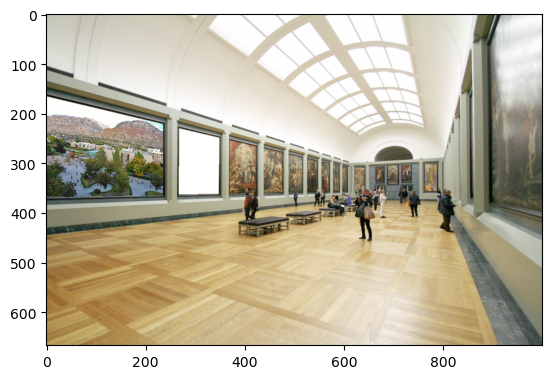

Slow Method: 4.917572021484375


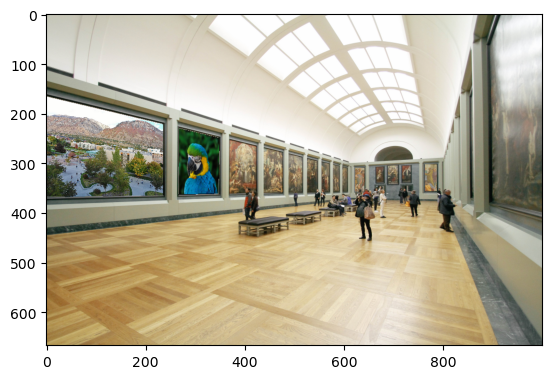

Fast Method: 0.38000059127807617


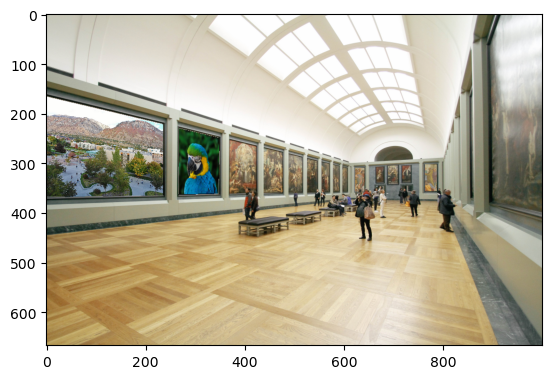

In [176]:
def composeFast(source_im, target_im, transform, bounding_box):
    hs, ws, _ = source_im.shape
    result = np.copy(target_im)

    inverse_transform = np.linalg.inv(transform)

    min_x, max_x, min_y, max_y = bounding_box

    for i in range(min_y, max_y + 1):
        for j in range(min_x, max_x + 1):
            target_coord = np.array([j, i, 1])
            source_coord = inverse_transform @ target_coord
            source_coord = np.squeeze(np.asarray(source_coord))

            source_x, source_y, w = source_coord
            if w != 0:
                source_x /= w
                source_y /= w

            if 0 <= source_x < ws and 0 <= source_y < hs:
                result[i, j] = interpolate(source_im, source_x, source_y)

    return result


def perspectiveWarpFast(source_im, target_im, s0, s1, s2, s3, t0, t1, t2, t3):
    result = np.copy(target_im)

    # Get the homography matrix
    homography = getHomography(s0, s1, s2, s3, t0, t1, t2, t3)

    # Calculate the bounding box for the target points
    x_coords = [t0.x, t1.x, t2.x, t3.x]
    y_coords = [t0.y, t1.y, t2.y, t3.y]

    min_x = int(np.amin(x_coords))
    max_x = int(np.amax(x_coords))
    min_y = int(np.amin(y_coords))
    max_y = int(np.amax(y_coords))

    bounding_box = (min_x, max_x, min_y, max_y)

    # Use the optimized compose function within the bounding box
    result = composeFast(source_im, target_im, homography, bounding_box)

    return result
    

from time import time
    
museum = plt.imread('museum.png')
plt.imshow(museum,vmin=0)
plt.show()

filename = "test.png"
im = plt.imread(filename)

h,w,_ = im.shape
        
s0 = Point(0,0)
s1 = Point(w-1,0)
s2 = Point(w-1,h-1)
s3 = Point(0,h-1)

t0 = Point(268,230)
t1 = Point(349,249)
t2 = Point(347,361)
t3 = Point(267,363)

#Points for nearest canvas
#t0 = Point(0,170)
#t1 = Point(235,222)
#t2 = Point(236,365)
#t3 = Point(0,368)


start = time()
result1 = perspectiveWarp(im,museum,s0,s1,s2,s3,t0,t1,t2,t3)
print("Slow Method:",time()-start)

plt.imshow(result1,vmin=0)
plt.show()

start = time()
result2 = perspectiveWarpFast(im,museum,s0,s1,s2,s3,t0,t1,t2,t3)
print("Fast Method:",time()-start)

#plt.imsave("Output.png",result2)
plt.imshow(result2,vmin=0)
plt.show()

# Part 5: QR Code Reader

We now have all the basic building blocks to make our own QR code reader. You will implement one for the last part of the lab. We will focus primarily the computer vision side of QR codes, which involves detecting, aligning, and discretizing QR codes so that they can be read properly.

### Understanding QR Codes

QR codes (short for Quick Response Codes) were invented in 1994, by the DENSO Corporation. These codes store data in two dimensions in the form of an array of contrasting regions. The information density of a QR code is much higher than a vanilla barcode; depending on the format used and the resolution of reader, over a thousand bytes can be encoded in a region the size of a postage stamp.

QR codes use a Reed–Solomon error correction based technology to help recover from errors in reading (for instance, caused by a smudge, badly printed code or other deformity).

Any QR code can be broken into the following sections:

<div style="width:60%;text-align:center;"><img src="qr-code-images/formatting.jpg" width=100%></div>

On three corners of a QR code are square blocks that the reader uses to coarsely identify and then align the code. These position markers always have a black/white/black/white/black ratio of 1:1:3:1:1, no matter the angle they are approached from.

<div style="width:30%;text-align:center;"><img src="qr-code-images/finder_pattern.jpg" width=100%></div>

The fourth point is called the alignment point and has a slightly different pattern and location. This allows the QR code to be properly oriented. Some smaller QR codes do not have this alignment block, so they approximate this location using an affine transform of the three given points.

Once these four points are identified, the image can be aligned using a homography and warping. The number of rows and columns in the QR code is determined by the timing information which alternates from black and white in both the vertical and horizontal direction. 

Once the image is aligned and the size determined, the QR code is discretized, undergoes an Xor with a particular mask given the format information, and read bit for bit in the following order:

<div style="width:60%;text-align:center;"><img src="qr-code-images/decoding.jpg" width=100%></div>

For more details about the decoding process, see the [DataGenetics Wounded QR Codes Blog](http://datagenetics.com/blog/november12013/index.html).

### Implementation

You will be implementing a QR code reader for 29x29 QR codes. The very first step of identifying the three corners using the 1:1:3:1:1 ratio has been implemented for you. For simplicity, the code does not return a fourth alignment point, but rather returns an axis-aligned point as if a corner was present, as shown in the figure. 

<div style="width:40%;text-align:center;"><img src="qr-code-images/keypoints.png" width=100%></div>

The very last step of taking a NumPy array of 1's and 0's and decoding it using the QR code standard has also been implemented for you. Your task is to implement everything inbetween.

To implement the QR code reader for a given input image:
- Feed the image into the provided `getCornerPoints` function to the get the x,y coordinates of the four corners.
- Use your `perspectiveWarp` to map the four points to an axis-aligned square centered on a 29x29 blank image (sometimes called a buffer or canvas).
- Discretize/threshold the image into True/False values.
- Feed the 29x29 grid into the provided `decode` function. A string will be returned with the QR code URL data.

**Remember that the locations of corners are not on the edge, but 4 pixels in on the 29x29 grid.** Once you have implemented the code, run it on the test cases below.

The decoder function depends on packages called `requests` and `BeautifulSoup` to run an online API call. You may need to `pip install` these packages if the decoder doesn't run properly.


In [177]:
from qr import getCornerPoints, decode

def scanQRcode(image):
    # Step 1: Get the corner points using getCornerPoints
    corner_points = getCornerPoints(image)
    if len(corner_points) != 4:
        raise ValueError("Incorrect number of corner points detected.")
    else: 
        print(corner_points)
    # Extract the corner points
    top_left = corner_points[0]
    top_right = corner_points[1]
    bottom_right = corner_points[3]
    bottom_left = corner_points[2]

    # Step 2: Use perspective warp to align the QR code to a square 29x29 image
    # Create points for a target 29x29 aligned QR code image
    target_size = 29
    s0 = top_left
    s1 = top_right
    s2 = bottom_right
    s3 = bottom_left

    # The target points represent a 29x29 canvas, starting 4 pixels in for alignment
    t0 = Point(3, 3)
    t1 = Point(25, 3)
    t2 = Point(25, 25)
    t3 = Point(3, 25)

    # Step 3: Create a blank 29x29 canvas to warp the QR code into
    canvas = np.zeros((target_size, target_size), dtype="float32")

    # Apply perspective warp to get an aligned version of the QR code
    aligned_qr = perspectiveWarp(image, canvas, s0, s1, s2, s3, t0, t1, t2, t3)

    # Plot the aligned QR code on the canvas
    plt.imshow(aligned_qr, cmap='gray', vmin=0, vmax=1)
    plt.title("Aligned QR Code on 29x29 Canvas")
    plt.show()

    # Step 4: Discretize the image to a 29x29 grid of True/False values
    threshold = 0.5  # Assume threshold for binarization
    binary_qr = aligned_qr > threshold

    # Ensure the array is of boolean type
    binary_qr = binary_qr.astype(bool)

    # Step 5: Decode the 29x29 grid using the provided decode function
    qr_data = decode(binary_qr)

    return qr_data

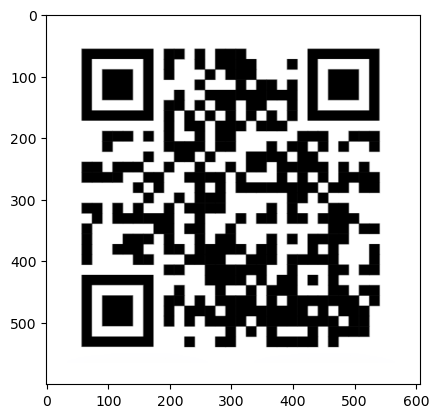

[(116,114), (483,114), (116,479), (483,479)]


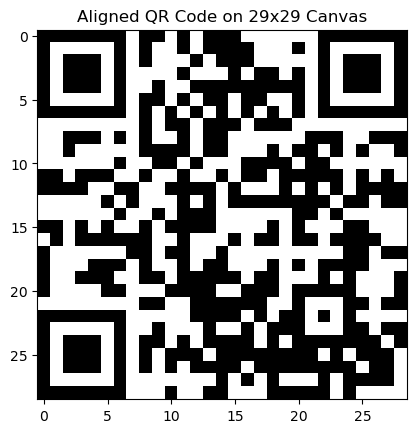

https://ecu.edu


In [178]:
image1 = plt.imread("qr-code-images/test1.png")
plt.imshow(image1);plt.show()
code1 = scanQRcode(image1)
print(code1)

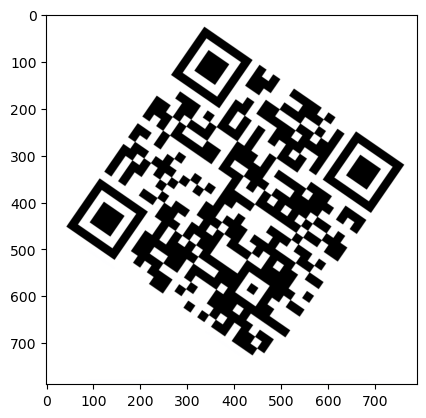

[(354,113), (677,336), (131,436), (454,659)]


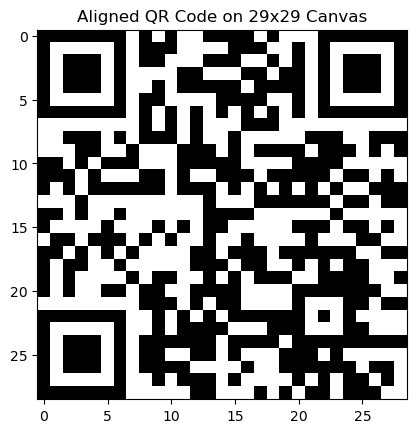

https://davidhartcv.com


In [181]:
image2 = plt.imread("qr-code-images/test2.png")
plt.imshow(image2);plt.show()
code2 = scanQRcode(image2)
print(code2)

### Extra Credit: Any Size QR Code Reader (10 pts)

The QR code reader you implemented will work for 29x29 QR codes, but QR codes can be many sizes. All QR codes have an odd number of bits per row and column and go up by 4, starting at size 21 (i.e. 21x21, 25x25, 29x29, ...). For 5 points extra credit, implement a QR code reader that works for any size from 21x21 up to 41x41.

To check if a QR code matches a given size, discretize the QR code asumming a 21x21 size. Then, determine if the timing information alternates in the appropriate manner (see the Understanding QR Codes for more information). If the timing information is valid, then you can assume that the QR code is the given size. If not, move up to the next size (25x25) and repeat.

You can check if your any-size QR code reader is working by running the following test case.

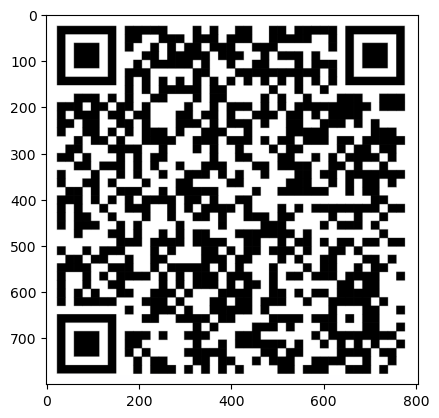

[(88,88), (712,88), (88,713), (712,713)]


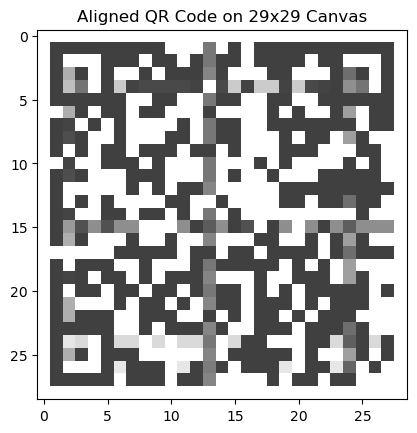

KeyError: 'Parsed Result'

In [182]:
image_ec = plt.imread("qr-code-images/extra_credit.png")
plt.imshow(image_ec);plt.show()
code_ec = scanQRcode(image_ec)
print(code_ec)